# Working with MLflow

Introduction to the use of MLflow

| Date | User | Change Type | Remarks |  
| ---- | ---- | ----------- | ------- |
| 06/01/2026   | Martin | Created   | Notebook to explore the use of MLflow | 
| 08/01/2026   | Martin | Updated   | Experiment tracking with Optuna | 

# Content

* [Introduction](#introduction)
* [MLflow with Optuna](#mlflow-with-optuna)
  - [Logging with callbacks](#using-logging-callbacks-for-tuning)

# Introduction

Showcasing basic logging on mlflow

In [9]:
import pandas as pd
import mlflow
import matplotlib.pyplot as plt
import os

from dotenv import dotenv_values
from sklearn.feature_extraction import DictVectorizer

In [10]:
config = dotenv_values("../.env")

os.environ["AWS_ACCESS_KEY_ID"] = config["MLFLOW_USER"]
os.environ["AWS_SECRET_ACCESS_KEY"] = config["MLFLOW_PASSWORD"]
os.environ["MLFLOW_S3_ENDPOINT_URL"] = "http://127.0.0.1:9000"
os.environ["MLFLOW_S3_IGNORE_TLS"] = "true"

mlflow.set_tracking_uri("http://127.0.0.1:5000")

In [11]:
# Set the mlflow experiment
mlflow.set_experiment("nyc-taxi-experiment")

<Experiment: artifact_location='s3://mlflow/3', creation_time=1767860156024, experiment_id='3', last_update_time=1767860156024, lifecycle_stage='active', name='nyc-taxi-experiment', tags={}>

In [77]:
# Load model
def read_dataframe(filename):
  if filename.endswith('.csv'):
    df = pd.read_csv(filename)

    df.lpep_dropoff_datetime = pd.to_datetime(df.lpep_dropoff_datetime)
    df.lpep_pickup_datetime = pd.to_datetime(df.lpep_pickup_datetime)
  elif filename.endswith('.parquet'):
    df = pd.read_parquet(filename)

  df['duration'] = df.lpep_dropoff_datetime - df.lpep_pickup_datetime
  df.duration = df.duration.apply(lambda td: td.total_seconds() / 60)

  df = df[(df.duration >= 1) & (df.duration <= 60)]

  categorical = ['PULocationID', 'DOLocationID', 'store_and_fwd_flag']
  df[categorical] = df[categorical].astype(str)
  
  return df

df_train = read_dataframe('../data/raw/green_tripdata_2025-01.parquet')
df_val = read_dataframe('../data/raw/green_tripdata_2025-02.parquet')

In [78]:
# Preprocessing
df_train['PU_DO'] = df_train['PULocationID'] + '_' + df_train['DOLocationID']
df_val['PU_DO'] = df_val['PULocationID'] + '_' + df_val['DOLocationID']

categorical = ['PU_DO', 'store_and_fwd_flag'] # ['PULocationID', 'DOLocationID']
numerical = ['trip_distance']
drop = ['RatecodeID', 'ehail_fee', 'PULocationID', 'DOLocationID', 'lpep_pickup_datetime', 'lpep_dropoff_datetime']

df_train[categorical] = df_train[categorical].astype('category')
df_val[categorical] = df_val[categorical].astype('category')

df_train = df_train.drop(drop, axis=1)
df_val = df_val.drop(drop, axis=1)

dv = DictVectorizer()

train_dicts = df_train[categorical + numerical].to_dict(orient='records')
X_train = dv.fit_transform(train_dicts)

val_dicts = df_val[categorical + numerical].to_dict(orient='records')
X_val = dv.transform(val_dicts)

target = 'duration'
y_train = df_train[target].values
y_val = df_val[target].values

In [ ]:
with mlflow.start_run():
  mlflow.set_tag("developer", "martin") # Tags: For easier searching

  mlflow.log_param("train-data-path", "data/raw/green_tripdata_2025-01.parquet") # Data
  mlflow.log_param("valid-data-path", "data/raw/green_tripdata_2025-02.parquet")

  alpha = 0.01
  mlflow.log_param("alpha", alpha) # Params: Log model paramters
  lr = Lasso(alpha)
  lr.fit(X_train, y_train)

  y_pred = lr.predict(X_val)

  rmse = root_mean_squared_error(y_val, y_pred) # Metrics: Log model results
  mlflow.log_metric("rmse", rmse)

🏃 View run traveling-bird-593 at: http://127.0.0.1:5000/#/experiments/2/runs/4145f38d4f924777b17cd402df808bfb
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/2


---

# MLflow with Optuna

Running MLflow with Optuna for hyperparameter search. Here we use the training and validation sets from the previous preprocessing

_Adapted from: https://mlflow.org/docs/latest/ml/traditional-ml/tutorials/hyperparameter-tuning/notebooks/hyperparameter-tuning-with-child-runs/_

In [ ]:
import math
import mlflow
import optuna
import numpy as np
import pandas as pd
import xgboost as xgb
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

Define some diagnostic plots and helper functions for experiment tracking

In [47]:
def plot_correlation(df, save_path=None):
  """
  Plots the correlation of each variable with the duration column

  Args:
      df (pd.DataFrame): DataFrame containing data with duration column
      save_path (str, optional): Path to save generated plot. Defaults to None.
  """
  # Calculate correlations
  df_corr = df.select_dtypes(include=['int', 'float'])
  correlations = df_corr.corr()['duration'].drop("duration").sort_values()

  colors = sns.diverging_palette(10, 130, as_cmap=True)
  color_mapped = correlations.map(colors)

  sns.set_style(
    "whitegrid", {"axes.facecolor": "#c2c4c2", "grid.linewidth": 1.5}
  )

  # Create plot
  fig = plt.figure(figsize=(12, 8))
  plt.barh(correlations.index, correlations.values, color=color_mapped)

  plt.title("Correlation with Duration", fontsize=18)
  plt.xlabel("Correlation Coefficient", fontsize=16)
  plt.ylabel("Variable", fontsize=16)
  plt.xticks(fontsize=14)
  plt.yticks(fontsize=14)
  plt.grid(axis="x")

  plt.tight_layout()

  # Save the plot if save_path is specified
  if save_path:
    plt.savefig(save_path, format="png", dpi=600)

  # prevent matplotlib from displaying the chart every time we call this function
  plt.close(fig)

  return fig

correlation_plot = plot_correlation(df_train)

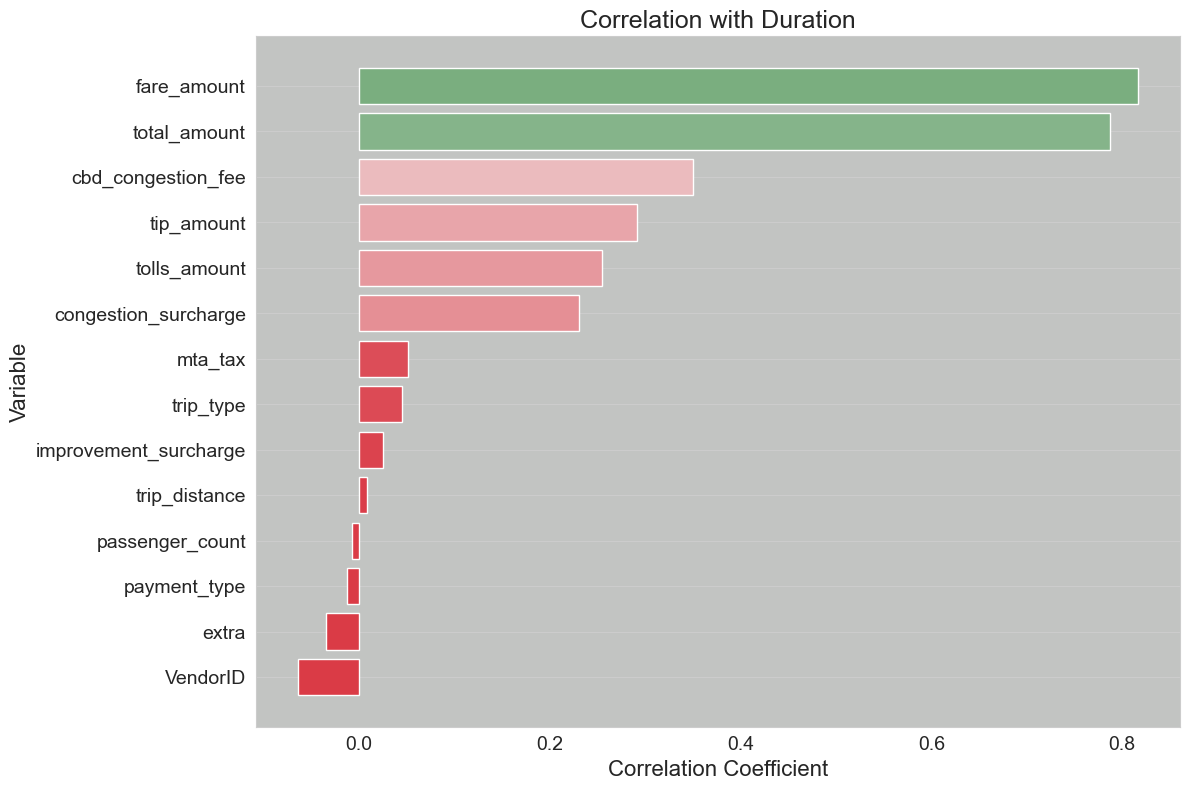

In [ ]:
correlation_plot

In [80]:
def plot_residuals(model, dvalid, valid_y, save_path=None):
  """
  Plots the residuals of the model predictions against the true values.

  Args:
  - model: The trained XGBoost model.
  - dvalid (xgb.DMatrix): The validation data in XGBoost DMatrix format.
  - valid_y (pd.Series): The true values for the validation set.
  - save_path (str, optional): Path to save the generated plot. If not specified, plot won't be saved.

  Returns:
  - None (Displays the residuals plot on a Jupyter window)
  """
  # Predict using the model
  preds = model.predict(dvalid)

  # Calculate residuals
  residuals = valid_y - preds

  # Set Seaborn style
  sns.set_style("whitegrid", {"axes.facecolor": "#c2c4c2", "grid.linewidth": 1.5})

  # Create scatter plot
  fig = plt.figure(figsize=(12, 8))
  plt.scatter(valid_y, residuals, color="blue", alpha=0.5)
  plt.axhline(y=0, color="r", linestyle="-")

  # Set labels, title and other plot properties
  plt.title("Residuals vs True Values", fontsize=18)
  plt.xlabel("True Values", fontsize=16)
  plt.ylabel("Residuals", fontsize=16)
  plt.xticks(fontsize=14)
  plt.yticks(fontsize=14)
  plt.grid(axis="y")

  plt.tight_layout()

  # Save the plot if save_path is specified
  if save_path:
    plt.savefig(save_path, format="png", dpi=600)

  # Show the plot
  plt.close(fig)

  return fig

In [81]:
def plot_feature_importance(model, booster):
  """
  Plots feature importance for an XGBoost model.

  Args:
  - model: A trained XGBoost model

  Returns:
  - fig: The matplotlib figure object
  """
  fig, ax = plt.subplots(figsize=(10, 8))
  importance_type = "weight" if booster == "gblinear" else "gain"
  xgb.plot_importance(
    model,
    importance_type=importance_type,
    ax=ax,
    title=f"Feature Importance based on {importance_type}",
  )
  plt.tight_layout()
  plt.close(fig)

  return fig

In [82]:
def get_or_create_experiment(experiment_name):
  """
  Retrieve the ID of an existing MLflow experiment or create a new one if it doesn't exist.

  This function checks if an experiment with the given name exists within MLflow.
  If it does, the function returns its ID. If not, it creates a new experiment
  with the provided name and returns its ID.

  Parameters:
  - experiment_name (str): Name of the MLflow experiment.

  Returns:
  - str: ID of the existing or newly created MLflow experiment.
  """

  if experiment := mlflow.get_experiment_by_name(experiment_name):
    return experiment.experiment_id
  else:
    return mlflow.create_experiment(experiment_name)

Perform a single run to test functionality

In [100]:
# mlflow.set_experiment("nyc-taxi-experiment")
experiment_id = get_or_create_experiment("nyc-taxi-experiment")

In [84]:
# Additional preprocessing
y_train = df_train['duration']
X_train = df_train.drop('duration', axis=1)

y_val = df_val['duration']
X_val = df_val.drop('duration', axis=1)

# Create xgb data formats
dtrain = xgb.DMatrix(X_train, label=y_train, enable_categorical=True)
dvalid = xgb.DMatrix(X_val, label=y_val, enable_categorical=True)

In [91]:
# Single model training loop
mlflow.xgboost.autolog()

params = {
  "objective": "reg:squarederror",
  "eval_metric": "rmse"
}
bst_model = xgb.train(
  params=params,
  dtrain=dtrain,
  num_boost_round=50,
)
preds = bst_model.predict(dvalid)
mean_squared_error(y_val, preds)

2026/01/08 17:20:25 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '5f5cf77acb5346fc859a0f847cc52f48', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current xgboost workflow
2026/01/08 17:20:26 WARNING mlflow.xgboost: Failed to infer model signature: could not sample data to infer model signature: please ensure that autologging is enabled before constructing the dataset.
2026/01/08 17:20:26 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


🏃 View run overjoyed-cow-608 at: http://127.0.0.1:5000/#/experiments/3/runs/5f5cf77acb5346fc859a0f847cc52f48
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/3


18.372021418974605

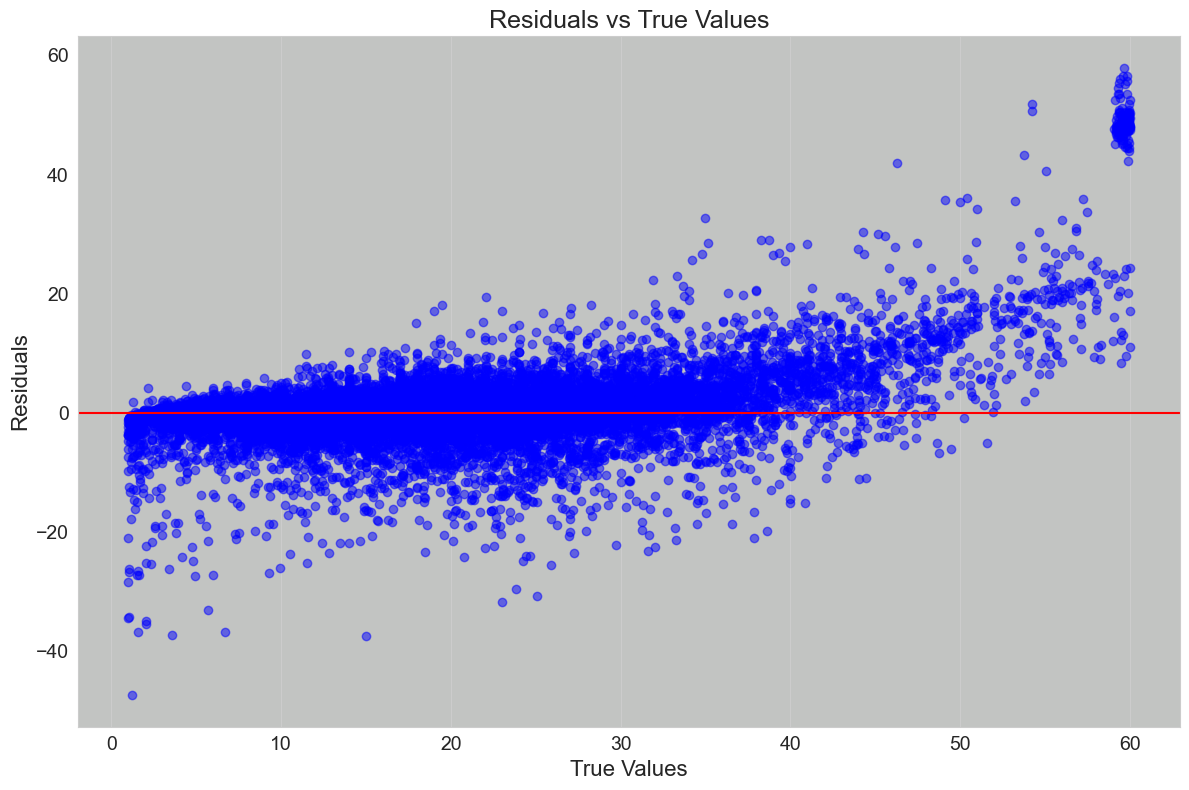

In [93]:
plot_residuals(bst_model, dvalid, y_val)

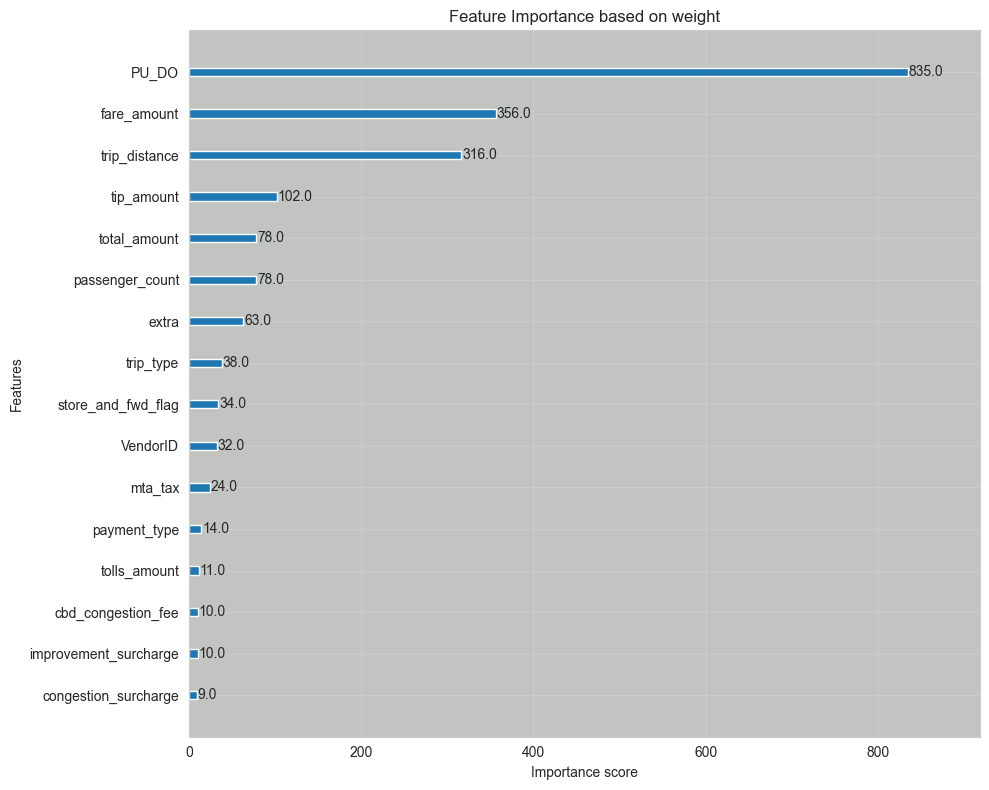

In [92]:
plot_feature_importance(bst_model, 'gblinear')

## Using logging callbacks for tuning

Optuna generates a lot of logs which may be overwhelming for tracking. Instead we only log results when a __new hyperparameter combination outperforms over the best metric__.

- __Enhanced Readability__ - Gauge the efficacy of our hyperparameter search. If we observe a diminishing frequency of 'best result' reports early on, it might suggest that fewer iterations would suffice to pinpoint an optimal hyperparameter set. On the other hand, a consistent rate of improvement might indicate that our feature set requires further refinement
- __Progress Indicators__ - Especially pertinent for extensive trials that span hours or even days, receiving periodic updates provides assurance that the process is still in motion. These 'heartbeat' notifications affirm that our system is diligently at work, even if it's not flooding stdout with every minute detail.


In [96]:
# Change optuna default logging to ERROR only
optuna.logging.set_verbosity(optuna.logging.ERROR)

def champion_callback(study, frozen_trial):
  """
  Logging callback that will report when a new trial iteration improves upon existing
  best trial values.

  Note: This callback is not intended for use in distributed computing systems such as Spark
  or Ray due to the micro-batch iterative implementation for distributing trials to a cluster's
  workers or agents.
  The race conditions with file system state management for distributed trials will render
  inconsistent values with this callback.
  """
  winner = study.user_attrs.get("winner", None)

  if study.best_value and winner != study.best_value:
    study.set_user_attr("winner", study.best_value)
    if winner:
      improvement_percent = (abs(winner - study.best_value) / study.best_value) * 100
      print(
        f"Trial {frozen_trial.number} achieved value: {frozen_trial.value} with "
        f"{improvement_percent:.4f}% improvement"
      )
    else:
      print(f"Initial trial {frozen_trial.number} achieved value: {frozen_trial.value}")

In [107]:
# Define the objective - What info is logged in each run
def objective(trial):
  with mlflow.start_run(nested=True):
    params = {
      "objective": "reg:squarederror",
      "eval_metric": "rmse",
      "booster": trial.suggest_categorical("booster", ["gbtree", "dart"]),
      "lambda": trial.suggest_float("lambda", 1e-8, 1.0, log=True),
      "alpha": trial.suggest_float("alpha", 1e-8, 1.0, log=True)
    }

    if params['booster'] == 'gbtree' or params['booster'] == 'dart':
      params["max_depth"] = trial.suggest_int("max_depth", 1, 9)
      params["eta"] = trial.suggest_float("eta", 1e-8, 1.0, log=True)
      params["gamma"] = trial.suggest_float("gamma", 1e-8, 1.0, log=True)
      params["grow_policy"] = trial.suggest_categorical(
          "grow_policy", ["depthwise", "lossguide"]
      )
    
    # Train model
    bst = xgb.train(params, dtrain)
    preds = bst.predict(dvalid)
    error = mean_squared_error(y_val, preds)

    # Logging to mlflow
    mlflow.log_params(params)
    mlflow.log_metric("mse", error)
    mlflow.log_metric("rmse", math.sqrt(error))

  return error

### Best practices

When naming your runs, consider the following:

1. Relevance to Code Changes: The name should reflect any code or parameter modifications made for that run.
2. Iterative Runs: If you're executing multiple runs iteratively, it's a good idea to update the run name for each iteration to avoid confusion.


In [121]:
parent_run = "fifth_attempt"

In [122]:

with mlflow.start_run(experiment_id=experiment_id, run_name=parent_run, nested=True):
  # Initialise optuna
  study = optuna.create_study(direction="minimize")

  # Initialise trials
  study.optimize(objective, n_trials=10, callbacks=[champion_callback])

  mlflow.log_params(study.best_params)
  mlflow.log_metric("best_mse", study.best_value)
  mlflow.log_metric("best_rmse", math.sqrt(study.best_value))

  # Log tags
  mlflow.set_tags(
    tags={
      "project": "NYC Taxi Duration",
      "optimizer_engine": "optuna",
      "model_family": "xgboost",
      "feature_set_version": 1
    }
  )

  # Log a fitted model with the best params
  model = xgb.train(study.best_params, dtrain)

  # Log the correlation plot
  mlflow.log_figure(figure=correlation_plot, artifact_file="correlation_plot.png")

  # Log the residual plot
  residuals = plot_residuals(model, dvalid, y_val)
  mlflow.log_figure(figure=residuals, artifact_file="residuals.png")

  # Log importance plot
  importances = plot_feature_importance(model, booster=study.best_params.get("booster"))
  mlflow.log_figure(figure=importances, artifact_file="importances.png")

  # Log the model
  artifact_path = "model"
  mlflow.xgboost.log_model(
    xgb_model=model,
    name=artifact_path,
    model_format='ubj',
    metadata={"model_data_version": 1}
  )

  # Get the logged model uri so that we can load it from the artifact store
  model_uri = mlflow.get_artifact_uri(artifact_path)

2026/01/08 18:26:29 WARNING mlflow.xgboost: Failed to infer model signature: could not sample data to infer model signature: please ensure that autologging is enabled before constructing the dataset.
2026/01/08 18:26:29 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


🏃 View run monumental-asp-558 at: http://127.0.0.1:5000/#/experiments/3/runs/0907c2239731400e9c67f9cf48b7bbcd
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/3
Initial trial 0 achieved value: 82.92421416722098


2026/01/08 18:26:34 WARNING mlflow.xgboost: Failed to infer model signature: could not sample data to infer model signature: please ensure that autologging is enabled before constructing the dataset.
2026/01/08 18:26:34 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


🏃 View run efficient-yak-466 at: http://127.0.0.1:5000/#/experiments/3/runs/1cbe812439114c11b4f4b85f489f4846
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/3
Trial 1 achieved value: 66.16844642998042 with 25.3229% improvement


2026/01/08 18:26:38 WARNING mlflow.xgboost: Failed to infer model signature: could not sample data to infer model signature: please ensure that autologging is enabled before constructing the dataset.
2026/01/08 18:26:38 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


🏃 View run learned-mink-152 at: http://127.0.0.1:5000/#/experiments/3/runs/518080d275d4474a9ab4d3e94b11a743
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/3


2026/01/08 18:26:42 WARNING mlflow.xgboost: Failed to infer model signature: could not sample data to infer model signature: please ensure that autologging is enabled before constructing the dataset.
2026/01/08 18:26:42 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


🏃 View run able-newt-938 at: http://127.0.0.1:5000/#/experiments/3/runs/55a7c28f858d416ab831f4625b875ccb
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/3


2026/01/08 18:26:45 WARNING mlflow.xgboost: Failed to infer model signature: could not sample data to infer model signature: please ensure that autologging is enabled before constructing the dataset.
2026/01/08 18:26:45 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


🏃 View run auspicious-lark-956 at: http://127.0.0.1:5000/#/experiments/3/runs/5ed0a06058ee429aa45c14a86f517b7a
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/3


2026/01/08 18:26:48 WARNING mlflow.xgboost: Failed to infer model signature: could not sample data to infer model signature: please ensure that autologging is enabled before constructing the dataset.
2026/01/08 18:26:48 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


🏃 View run abrasive-kit-664 at: http://127.0.0.1:5000/#/experiments/3/runs/68e12355d7c842009e06ed7a461acb56
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/3


2026/01/08 18:26:52 WARNING mlflow.xgboost: Failed to infer model signature: could not sample data to infer model signature: please ensure that autologging is enabled before constructing the dataset.
2026/01/08 18:26:52 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


🏃 View run nervous-rat-200 at: http://127.0.0.1:5000/#/experiments/3/runs/03d592ce45994aaba8417d02cdffa842
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/3
Trial 6 achieved value: 58.71481614890795 with 12.6946% improvement


2026/01/08 18:26:56 WARNING mlflow.xgboost: Failed to infer model signature: could not sample data to infer model signature: please ensure that autologging is enabled before constructing the dataset.
2026/01/08 18:26:56 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


🏃 View run bouncy-lark-219 at: http://127.0.0.1:5000/#/experiments/3/runs/cd684586d2764e9eaefc91e7616a62e4
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/3
Trial 7 achieved value: 52.064700987628456 with 12.7728% improvement


2026/01/08 18:26:59 WARNING mlflow.xgboost: Failed to infer model signature: could not sample data to infer model signature: please ensure that autologging is enabled before constructing the dataset.
2026/01/08 18:26:59 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


🏃 View run colorful-boar-443 at: http://127.0.0.1:5000/#/experiments/3/runs/c26b2592b0d54fe284491b25ad08949a
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/3


2026/01/08 18:27:03 WARNING mlflow.xgboost: Failed to infer model signature: could not sample data to infer model signature: please ensure that autologging is enabled before constructing the dataset.
2026/01/08 18:27:03 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


🏃 View run flawless-skink-418 at: http://127.0.0.1:5000/#/experiments/3/runs/4edf318d02eb44eea3de208f1af34b21
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/3


2026/01/08 18:27:06 WARNING mlflow.xgboost: Failed to infer model signature: could not sample data to infer model signature: please ensure that autologging is enabled before constructing the dataset.
2026/01/08 18:27:06 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


🏃 View run fifth_attempt at: http://127.0.0.1:5000/#/experiments/3/runs/8a8af1ded1264ae0b46eeeec8fa4ffdc
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/3


In [137]:
model_uri

's3://mlflow/3/8a8af1ded1264ae0b46eeeec8fa4ffdc/artifacts/model'

In [ ]:
# Loading a model
results = mlflow.search_runs(
  experiment_ids=[experiment_id],
  order_by=["metrics.rmse DESC"]
)
run_id = results.loc[, "run_id"]
loaded_model = mlflow.xgboost.load_model(f"runs:/{run_id}/model")

In [135]:
loaded_model.predict(dvalid)

array([10.596291, 16.933348, 19.378036, ..., 16.185493, 13.94279 ,
       16.185493], shape=(44218,), dtype=float32)

In [143]:
loaded_model

In [ ]:
%load_ext watermark
%watermark